In [232]:
import pandas as pd
df = pd.read_csv("/tmp/temp.csv")

In [233]:
df['buy_amount'] = df['buy_amount'].divide(df['mid'])
df['sell_amount'] = df['sell_amount'].divide(df['mid'])

In [234]:
diff = df[['mid', 'balance']]
diff = diff.pct_change().dropna()
dd = diff.cumsum(axis=0).iloc[:-10]

/home/pravin/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


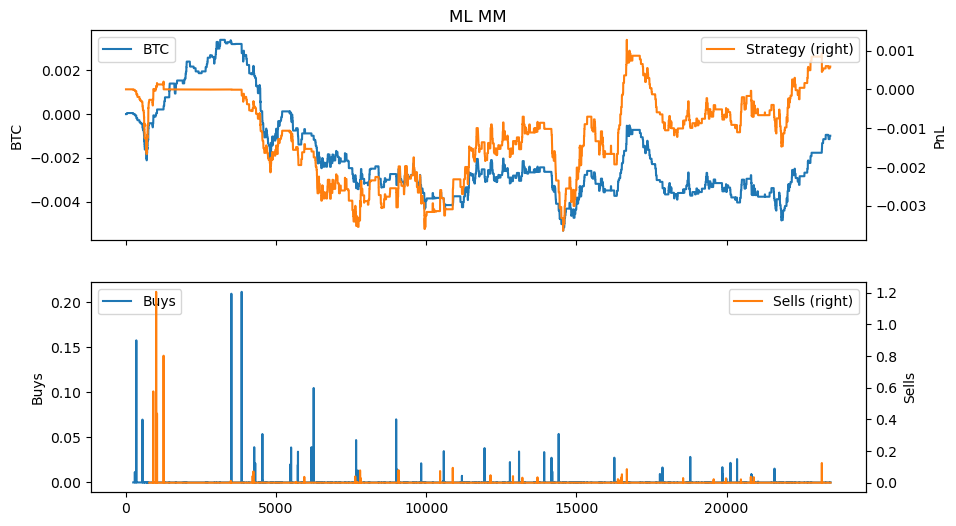

In [235]:
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 20))
dd['mid'].plot(label='BTC', figsize=(10, 6), ax=ax1)
dd['balance'].plot(secondary_y=True, label='Strategy', ax=ax1)

ax1.set_ylabel('BTC')
ax1.right_ax.set_ylabel('PnL')
plt.title('ML MM')
ax1.legend(loc='upper left')
ax1.right_ax.legend(loc='upper right')

df['buy_amount'] = np.log(df['buy_amount'])
df['sell_amount'] = np.log(df['sell_amount'])
df['buy_amount'].diff().dropna().plot(label="Buys", ax=ax2)
df['sell_amount'].diff().dropna().plot(label='Sells', secondary_y=True, ax=ax2)
ax2.set_ylabel('Buys')
ax2.right_ax.set_ylabel('Sells')
ax2.legend(loc='upper left')
ax2.right_ax.legend(loc='upper right')
plt.show()

<Axes: >

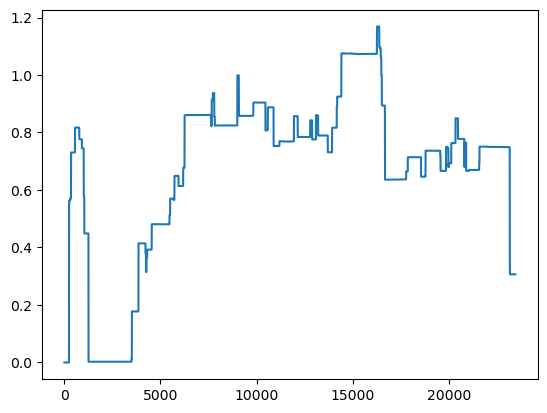

In [236]:
df['leverage'].plot()